In [33]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

import functions_IMU
import functions_generell
import functions_PRESSURE

## DATEN EINLESEN FÜR ALLE TEILNEHMER

In [34]:
#%% Daten einlesen für alle Teilnehmer-------------------------------------------------------------------------------------------
# liste der Teilneher
participants = ['ID_1_Dabisch_Samuel', 'ID_2_Pohl_Jannis', 'ID_3_Kleber_Christian',
                'ID_4_Schröter_Till', 'ID_5_Zaschke_Lenard', 'ID_6_Petroll_Finn', 'ID_7_Gruber_Julius']

# Alle Daten der Teilnehmer einlesen und verarbeiten
all_data = {}

for participant in participants:
    folder_path = os.path.join('data_final', participant)
    
    # Lade die 6 CSV-Dateien für den Teilnehmer
    real_1, real_2, vr_1, vr_2, mvc_beine, mvc_hals = functions_generell.load_csvs(folder_path)
    
    # Speichere die DataFrames im Dictionary
    all_data[participant] = {
        'REAL_1': real_1,
        'REAL_2': real_2,
        'VR_1': vr_1,
        'VR_2': vr_2,
        'MVC_Beine': mvc_beine,
        'MVC_Hals': mvc_hals
    }
    
    print(f"Daten für {participant} geladen")

print(f"\nAlle Daten geladen! {len(all_data)} Teilnehmer erfolgreich eingelesen.")

Daten für ID_1_Dabisch_Samuel geladen
Daten für ID_2_Pohl_Jannis geladen
Daten für ID_3_Kleber_Christian geladen
Daten für ID_4_Schröter_Till geladen
Daten für ID_5_Zaschke_Lenard geladen
Daten für ID_6_Petroll_Finn geladen
Daten für ID_7_Gruber_Julius geladen

Alle Daten geladen! 7 Teilnehmer erfolgreich eingelesen.


## EMG FILTER (30-500 HZ) + 50ms RMS

In [35]:
def _infer_fs_from_time(t: np.ndarray) -> float:
    t = np.asarray(t, dtype=float)
    dt = np.diff(t)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        raise ValueError("Kann fs nicht aus time ableiten (time hat keine positiven Abstände).")
    return 1.0 / np.median(dt)

def _bandpass_filter(x: np.ndarray, fs: float, low: float = 30.0, high: float = 500.0, order: int = 4) -> np.ndarray:
    nyq = fs / 2.0
    high = min(high, nyq * 0.999)  # falls fs klein ist
    if low >= high:
        raise ValueError(f"Ungültige Bandpass-Grenzen: low={low}, high={high}, nyq={nyq}")
    b, a = butter(order, [low / nyq, high / nyq], btype="bandpass")
    x = np.asarray(x, dtype=float)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    return filtfilt(b, a, x)

def _moving_rms(x: np.ndarray, fs: float, window_ms: float = 50.0) -> np.ndarray:
    win = int(round((window_ms / 1000.0) * fs))
    win = max(win, 1)
    x2 = np.asarray(x, dtype=float) ** 2
    kernel = np.ones(win, dtype=float) / win
    mean_sq = np.convolve(x2, kernel, mode="same")
    return np.sqrt(mean_sq)

def get_emg_cols(df: pd.DataFrame):
    # EMG-Spalten erkennen (typisch: "(uV)" im Namen)
    return [c for c in df.columns if re.search(r"\(uV\)", str(c))]

def filter_emg_in_df(df: pd.DataFrame, time_col: str = "time", emg_cols=None,
                     low=30.0, high=500.0, rms_ms=50.0, bp_order=4,
                     suffix_filt="_bp", suffix_rms="_rms50"):
    if emg_cols is None:
        emg_cols = get_emg_cols(df)
    if len(emg_cols) == 0:
        return df  # nichts zu tun
    
    fs = _infer_fs_from_time(df[time_col].to_numpy())
    
    for col in emg_cols:
        x = df[col].to_numpy()
        x_bp = _bandpass_filter(x, fs, low=low, high=high, order=bp_order)
        x_rms = _moving_rms(x_bp, fs, window_ms=rms_ms)
        df[col + suffix_filt] = x_bp
        df[col + suffix_rms] = x_rms
    
    return df

# Auf ALLE Datensätze anwenden (REAL/VR + MVC)
trials_to_filter = ["REAL_1", "REAL_2", "VR_1", "VR_2", "MVC_Beine", "MVC_Hals"]

for participant, pdata in all_data.items():
    for trial in trials_to_filter:
        if trial in pdata and pdata[trial] is not None:
            all_data[participant][trial] = filter_emg_in_df(all_data[participant][trial])
    print(f"EMG gefiltert + RMS für {participant}")

EMG gefiltert + RMS für ID_1_Dabisch_Samuel
EMG gefiltert + RMS für ID_2_Pohl_Jannis
EMG gefiltert + RMS für ID_3_Kleber_Christian
EMG gefiltert + RMS für ID_4_Schröter_Till
EMG gefiltert + RMS für ID_5_Zaschke_Lenard
EMG gefiltert + RMS für ID_6_Petroll_Finn
EMG gefiltert + RMS für ID_7_Gruber_Julius


## MVC PEAKS BERECHNEN + TRIALS AUF %MVC NORMALISIEREN

In [36]:
# Welche Muskeln zu Beine/Hals gehören (genau wie in deinen CSV-Spaltennamen)
LEG_MUSCLES  = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)", "RT TIB.ANT. (uV)"]
NECK_MUSCLES = ["RT SCM (uV)", "RT CERVICAL PS (uV)"]

RMS_SUFFIX = "_rms50"  # von deinem Filtercode

def get_mvc_peak(df_mvc: pd.DataFrame, muscle_col_raw: str, rms_suffix="_rms50"):
    """
    Peak aus MVC Datensatz holen (Peak vom RMS Signal).
    """
    col = muscle_col_raw + rms_suffix
    if col not in df_mvc.columns:
        raise KeyError(f"{col} nicht im MVC-DataFrame gefunden.")
    return float(np.nanmax(df_mvc[col].to_numpy()))

def normalize_trial_to_mvc(df_trial: pd.DataFrame, mvc_peaks: dict, rms_suffix="_rms50", out_suffix="_pctMVC"):
    """
    Erstellt neue Spalten: <Muskel>_rms50_pctMVC
    """
    for muscle_raw, peak in mvc_peaks.items():
        rms_col = muscle_raw + rms_suffix
        out_col = muscle_raw + rms_suffix + out_suffix

        if rms_col not in df_trial.columns:
            continue

        if peak is None or peak <= 0 or np.isnan(peak):
            df_trial[out_col] = np.nan
        else:
            df_trial[out_col] = df_trial[rms_col] / peak * 100.0  # %MVC

    return df_trial

# Speichert MVC Peaks pro Proband
mvc_peaks_all = {}

# Trials die normalisiert werden sollen
TRIALS_TO_NORMALIZE = ["REAL_1", "REAL_2", "VR_1", "VR_2"]

for participant in participants:
    df_mvc_leg  = all_data[participant]["MVC_Beine"]
    df_mvc_neck = all_data[participant]["MVC_Hals"]

    mvc_peaks = {}

    # Bein Peaks aus MVC_Beine
    for m in LEG_MUSCLES:
        if m in df_mvc_leg.columns:
            mvc_peaks[m] = get_mvc_peak(df_mvc_leg, m, rms_suffix=RMS_SUFFIX)
        else:
            mvc_peaks[m] = None

    # Hals Peaks aus MVC_Hals
    for m in NECK_MUSCLES:
        if m in df_mvc_neck.columns:
            mvc_peaks[m] = get_mvc_peak(df_mvc_neck, m, rms_suffix=RMS_SUFFIX)
        else:
            mvc_peaks[m] = None

    mvc_peaks_all[participant] = mvc_peaks

    # Normalisieren aller REAL/VR Trials
    for trial in TRIALS_TO_NORMALIZE:
        df_trial = all_data[participant][trial]
        all_data[participant][trial] = normalize_trial_to_mvc(
            df_trial, mvc_peaks, rms_suffix=RMS_SUFFIX, out_suffix="_pctMVC"
        )

    print(f"%MVC normalisiert für {participant}")

%MVC normalisiert für ID_1_Dabisch_Samuel
%MVC normalisiert für ID_2_Pohl_Jannis
%MVC normalisiert für ID_3_Kleber_Christian
%MVC normalisiert für ID_4_Schröter_Till
%MVC normalisiert für ID_5_Zaschke_Lenard
%MVC normalisiert für ID_6_Petroll_Finn
%MVC normalisiert für ID_7_Gruber_Julius


## NORMALISIERTE EMG DATEN EXPORTIEREN
## -> Muss einmal ausgeführt werden (weil Daten ändern sich ja dann nicht mehr)

In [37]:
#%% EXPORT %MVC Daten (muss einmal gemacht werden)
import os

OUT_DIR = "data_processed_pctMVC"
TRIALS_EXPORT = ["REAL_1", "REAL_2", "VR_1", "VR_2"]

os.makedirs(OUT_DIR, exist_ok=True)

for participant in participants:
    p_dir = os.path.join(OUT_DIR, participant)
    os.makedirs(p_dir, exist_ok=True)

    for trial in TRIALS_EXPORT:
        df = all_data[participant][trial]
        out_path = os.path.join(p_dir, f"{trial}_pctMVC.csv")
        df.to_csv(out_path, sep=";", index=False)

print("Export fertig ->", OUT_DIR)

Export fertig -> data_processed_pctMVC


## !!!!! NUR AUSFÜHREN WENN MAN ALLE PLOTS SEHEN WILL !!!!!!

In [ ]:
#%% PLOTS: %MVC (je Proband, je Versuch einzeln, je Muskel einzeln)  -----------------


LEG_MUSCLES  = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)", "RT TIB.ANT. (uV)"]
NECK_MUSCLES = ["RT SCM (uV)", "RT CERVICAL PS (uV)"]

TRIALS_TO_PLOT = ["REAL_1", "REAL_2", "VR_1", "VR_2"]
TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"

def plot_all_pctmvc_all_participants(all_data, participants,
                                     muscles_raw,
                                     trials=TRIALS_TO_PLOT,
                                     time_col=TIME_COL,
                                     rms_suffix=RMS_SUFFIX,
                                     out_suffix=OUT_SUFFIX,
                                     figsize=(12, 4)):
    for participant in participants:
        for trial in trials:
            df = all_data[participant].get(trial, None)
            if df is None:
                continue

            for muscle_raw in muscles_raw:
                col = muscle_raw + rms_suffix + out_suffix
                if col not in df.columns:
                    continue

                plt.figure(figsize=figsize)
                plt.plot(df[time_col], df[col])
                plt.title(f"{participant} | {trial} | Muskel: {muscle_raw} | %MVC")
                plt.xlabel("time [s]")
                plt.ylabel("%MVC")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

# Beine:
plot_all_pctmvc_all_participants(all_data, participants, LEG_MUSCLES)

# Hals:
plot_all_pctmvc_all_participants(all_data, participants, NECK_MUSCLES)

## MEAN PLOTS + STANDARTABWEICHUNG DER BEINMUSKULATUR WÄHREND DES ABSPRUNGS
## Pro Bedingung (Real / VR)

In [ ]:
#%% Jump-Timestamps + %MVC Sprünge (0–100%) + Mean±SD + SD-Label + MUSKEL-EXCLUDES ----
JUMP_DIR = "jump_analysis_results_knee"

TRIALS_REAL = ["REAL_1", "REAL_2"]
TRIALS_VR   = ["VR_1", "VR_2"]

TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"

# NUR Beine (ohne Tib.Ant.)
LEG_MUSCLES  = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)"]
MUSCLES_TO_PLOT = LEG_MUSCLES

N_POINTS = 101  # 0..100%

# --------- EXCLUDES NUR FÜR EINEN MUSKEL IN EINEM TRIAL (aus deinem Bild) ----------
# Jannis: REAL2 Biceps Fem
# Chris:  REAL1 Biceps Fem
# Till:   REAL2 Biceps Fem + VR1 Biceps Fem
MUSCLE_EXCLUDES = {
    "ID_2_Pohl_Jannis": {
        "REAL_2": ["RT BICEPS FEM. (uV)"],
    },
    "ID_3_Kleber_Christian": {
        "REAL_1": ["RT BICEPS FEM. (uV)"],
    },
    "ID_4_Schröter_Till": {
        "REAL_2": ["RT BICEPS FEM. (uV)"],
        "VR_1":   ["RT BICEPS FEM. (uV)"],
    },
}

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "start_analyse", "t_absprung", "messung"])
    return jumps

def extract_jump_segments(df_trial: pd.DataFrame, jumps_trial: pd.DataFrame, time_col="time"):
    segments = []
    for _, r in jumps_trial.iterrows():
        jn = int(r["sprung nr."])
        t0 = float(r["start_analyse"])
        t1 = float(r["t_absprung"])
        if t1 <= t0:
            continue

        mask = (df_trial[time_col] >= t0) & (df_trial[time_col] <= t1)
        seg = df_trial.loc[mask].copy()
        if len(seg) < 2:
            continue
        seg["sprung nr."] = jn
        segments.append(seg)
    return segments

def resample_to_percent(seg: pd.DataFrame, value_col: str, time_col="time", n_points=101):
    t = seg[time_col].to_numpy(dtype=float)
    y = seg[value_col].to_numpy(dtype=float)

    mask = np.isfinite(t) & np.isfinite(y)
    t = t[mask]; y = y[mask]
    if t.size < 2:
        return None

    t0, t1 = t[0], t[-1]
    if t1 <= t0:
        return None

    tn = (t - t0) / (t1 - t0)
    x_new = np.linspace(0, 1, n_points)
    y_new = np.interp(x_new, tn, y)
    return y_new

def is_muscle_excluded(participant: str, trial: str, muscle_raw: str) -> bool:
    return muscle_raw in MUSCLE_EXCLUDES.get(participant, {}).get(trial, [])

def plot_mean_sd_pctmvc_for_participant(participant: str, all_data, jumps_df: pd.DataFrame,
                                        muscles_raw, trials_group, group_name="REAL",
                                        time_col="time", n_points=101):
    x = np.linspace(0, 100, n_points)

    for muscle_raw in muscles_raw:
        col = muscle_raw + RMS_SUFFIX + OUT_SUFFIX

        curves = []
        used_trials = []
        excluded_trials_for_this_muscle = []

        for trial in trials_group:
            if is_muscle_excluded(participant, trial, muscle_raw):
                excluded_trials_for_this_muscle.append(trial)
                continue  # <-- nur dieser Muskel in diesem Trial wird übersprungen

            df_trial = all_data[participant].get(trial, None)
            if df_trial is None:
                continue
            if col not in df_trial.columns:
                continue

            jumps_trial = jumps_df[jumps_df["messung"] == trial]
            if jumps_trial.empty:
                continue

            segments = extract_jump_segments(df_trial, jumps_trial, time_col=time_col)

            for seg in segments:
                y_new = resample_to_percent(seg, col, time_col=time_col, n_points=n_points)
                if y_new is not None:
                    curves.append(y_new)
                    used_trials.append(trial)

        if len(curves) == 0:
            print(f"Keine Sprünge für {participant} | {group_name} | {muscle_raw}")
            continue

        Y = np.vstack(curves)
        mean = np.nanmean(Y, axis=0)
        sd   = np.nanstd(Y, axis=0)

        sd_mean_pp = float(np.nanmean(sd))
        sd_max_pp  = float(np.nanmax(sd))

        plt.figure(figsize=(12, 5))

        for y in Y:
            plt.plot(x, y, alpha=0.15)

        plt.plot(x, mean, linewidth=2,
                 label=f"Mean | SD(avg)={sd_mean_pp:.2f} pp | SD(max)={sd_max_pp:.2f} pp")
        plt.fill_between(x, mean - sd, mean + sd, alpha=0.25, label="±1 SD")

        excl_txt = ""
        if excluded_trials_for_this_muscle:
            excl_txt = f" | excluded {muscle_raw} in: {', '.join(sorted(set(excluded_trials_for_this_muscle)))}"

        plt.title(f"{participant} | {group_name} | {muscle_raw} | %MVC | Mean ± SD (n={Y.shape[0]}){excl_txt}")
        plt.xlabel("Sprungdauer [%]")
        plt.ylabel("%MVC")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# --------- Ausführen für alle Participants ----------
for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    plot_mean_sd_pctmvc_for_participant(
        participant, all_data, jumps_df,
        muscles_raw=MUSCLES_TO_PLOT,
        trials_group=TRIALS_REAL,
        group_name="REAL",
        time_col=TIME_COL,
        n_points=N_POINTS
    )

    plot_mean_sd_pctmvc_for_participant(
        participant, all_data, jumps_df,
        muscles_raw=MUSCLES_TO_PLOT,
        trials_group=TRIALS_VR,
        group_name="VR",
        time_col=TIME_COL,
        n_points=N_POINTS
    )

## RT SCM MITTELWERT + STANDARTABWEICHUNG PRO SPRUNG

In [ ]:
#%% Absprung-zentriertes Zeitfenster: Mean ± SD (RT SCM) | [-0.5s, +1.0s] | REAL vs VR ----
JUMP_DIR = "jump_analysis_results_knee"

TRIALS_REAL = ["REAL_1", "REAL_2"]
TRIALS_VR   = ["VR_1", "VR_2"]

TIME_COL = "time"

MUSCLE_RAW = "RT SCM (uV)"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"

WINDOW_PRE  = 0.5   # Sekunden vor Absprung
WINDOW_POST = 1.0   # Sekunden nach Absprung

N_POINTS = 151  # fixe Anzahl Samples im Fenster (Resampling)

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "t_absprung", "messung"])
    return jumps

def get_signal_col(df: pd.DataFrame, muscle_raw: str) -> str:
    col_pct = muscle_raw + RMS_SUFFIX + OUT_SUFFIX
    col_rms = muscle_raw + RMS_SUFFIX
    if col_pct in df.columns:
        return col_pct
    if col_rms in df.columns:
        return col_rms
    raise KeyError(f"Keine passende Spalte gefunden: '{col_pct}' oder '{col_rms}'")

def resample_fixed_window(t_rel: np.ndarray, y: np.ndarray, n_points: int,
                          t_min: float, t_max: float):
    """
    Resample auf fixes Zeitraster (linear interp) von t_min..t_max
    """
    mask = np.isfinite(t_rel) & np.isfinite(y)
    t_rel = t_rel[mask]
    y = y[mask]
    if t_rel.size < 2:
        return None

    # sicherstellen, dass t_rel aufsteigend ist
    order = np.argsort(t_rel)
    t_rel = t_rel[order]
    y = y[order]

    x_new = np.linspace(t_min, t_max, n_points)
    y_new = np.interp(x_new, t_rel, y)
    return x_new, y_new

def plot_absprung_window_mean_sd_for_participant(participant: str, all_data, jumps_df: pd.DataFrame,
                                                 trials_group, group_name="REAL"):
    # Ref DF um Spalten zu checken
    df_ref = None
    for t in trials_group:
        if all_data[participant].get(t, None) is not None:
            df_ref = all_data[participant][t]
            break
    if df_ref is None:
        print(f"Keine Daten für {participant} ({group_name})")
        return

    sig_col = get_signal_col(df_ref, MUSCLE_RAW)
    ylab = "%MVC" if sig_col.endswith(OUT_SUFFIX) else "EMG RMS [uV]"

    curves = []

    for trial in trials_group:
        df = all_data[participant].get(trial, None)
        if df is None or TIME_COL not in df.columns:
            continue
        if sig_col not in df.columns:
            continue

        jsub = jumps_df[jumps_df["messung"] == trial]
        if jsub.empty:
            continue

        t = df[TIME_COL].to_numpy(dtype=float)
        y = df[sig_col].to_numpy(dtype=float)

        for _, r in jsub.iterrows():
            t_abs = float(r["t_absprung"])
            t0 = t_abs - WINDOW_PRE
            t1 = t_abs + WINDOW_POST

            mask = (t >= t0) & (t <= t1)
            if np.sum(mask) < 2:
                continue

            t_rel = t[mask] - t_abs   # Absprung = 0
            y_seg = y[mask]

            res = resample_fixed_window(t_rel, y_seg, N_POINTS, -WINDOW_PRE, WINDOW_POST)
            if res is None:
                continue

            x_new, y_new = res
            curves.append(y_new)

    if len(curves) == 0:
        print(f"Keine Segmente für {participant} ({group_name})")
        return

    Y = np.vstack(curves)  # (n_jumps, N_POINTS)
    mean = np.nanmean(Y, axis=0)
    sd   = np.nanstd(Y, axis=0)

    sd_mean_pp = float(np.nanmean(sd))
    sd_max_pp  = float(np.nanmax(sd))

    plt.figure(figsize=(12, 5))

    # einzelne Sprünge transparent
    for y_curve in Y:
        plt.plot(x_new, y_curve, alpha=0.12)

    # Mean ± SD
    plt.plot(x_new, mean, linewidth=2,
             label=f"Mean | SD(avg)={sd_mean_pp:.2f} pp | SD(max)={sd_max_pp:.2f} pp")
    plt.fill_between(x_new, mean - sd, mean + sd, alpha=0.25, label="±1 SD")

    plt.axvline(0, linestyle="--", linewidth=2, label="Absprung")

    plt.title(f"{participant} | {group_name} | {MUSCLE_RAW} | Mean ± SD | Fenster: -{WINDOW_PRE}s bis +{WINDOW_POST}s (n={Y.shape[0]})")
    plt.xlabel("Zeit relativ zum Absprung [s]")
    plt.ylabel(ylab)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------- Ausführen: pro Proband 1 Plot REAL + 1 Plot VR ----------
for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    plot_absprung_window_mean_sd_for_participant(
        participant, all_data, jumps_df,
        trials_group=TRIALS_REAL,
        group_name="REAL"
    )

    plot_absprung_window_mean_sd_for_participant(
        participant, all_data, jumps_df,
        trials_group=TRIALS_VR,
        group_name="VR"
    )

In [ ]:
#%% Tabelle: pro Proband & pro Sprung -> Max-Peak EMG (Beine ohne TibAnt) + Excludes + CSV pro Proband
JUMP_DIR = "jump_analysis_results_knee"

TRIALS = ["REAL_1", "REAL_2", "VR_1", "VR_2"]
TIME_COL = "time"

# Beine OHNE Tib Ant:
LEG_MUSCLES_NO_TA = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)"]

RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"   # nimmt %MVC wenn vorhanden, sonst RMS

# --------- EXCLUDES NUR FÜR EINEN MUSKEL IN EINEM TRIAL ----------
# Jannis: REAL2 Biceps Fem
# Chris:  REAL1 Biceps Fem
# Till:   REAL2 Biceps Fem + VR1 Biceps Fem
MUSCLE_EXCLUDES = {
    "ID_2_Pohl_Jannis": {"REAL_2": ["RT BICEPS FEM. (uV)"]},
    "ID_3_Kleber_Christian": {"REAL_1": ["RT BICEPS FEM. (uV)"]},
    "ID_4_Schröter_Till": {"REAL_2": ["RT BICEPS FEM. (uV)"], "VR_1": ["RT BICEPS FEM. (uV)"]},
}

def is_muscle_excluded(participant: str, trial: str, muscle_raw: str) -> bool:
    return muscle_raw in MUSCLE_EXCLUDES.get(participant, {}).get(trial, [])

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "start_analyse", "t_absprung", "messung"])
    return jumps

def pick_signal_col(df: pd.DataFrame, muscle_raw: str) -> str:
    col_pct = muscle_raw + RMS_SUFFIX + OUT_SUFFIX
    col_rms = muscle_raw + RMS_SUFFIX
    if col_pct in df.columns:
        return col_pct
    if col_rms in df.columns:
        return col_rms
    return None

rows = []

for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    for _, r in jumps_df.iterrows():
        trial = str(r["messung"]).strip()
        if trial not in TRIALS:
            continue

        df = all_data[participant].get(trial, None)
        if df is None:
            continue
        if TIME_COL not in df.columns:
            continue

        t0 = float(r["start_analyse"])
        t1 = float(r["t_absprung"])
        if t1 <= t0:
            continue

        mask = (df[TIME_COL] >= t0) & (df[TIME_COL] <= t1)
        if mask.sum() < 2:
            continue

        row = {
            "participant": participant,
            "trial": trial,
            "sprung_nr": int(r["sprung nr."]),
            "t_start": t0,
            "t_end": t1,
        }

        for m in LEG_MUSCLES_NO_TA:
            colname_out = m.replace(" (uV)", "") + "_max"

            # EXCLUDE: nur dieser Muskel in diesem Trial -> NaN
            if is_muscle_excluded(participant, trial, m):
                row[colname_out] = np.nan
                continue

            col = pick_signal_col(df, m)
            if col is None:
                row[colname_out] = np.nan
                continue

            vals = df.loc[mask, col].to_numpy(dtype=float)
            row[colname_out] = float(np.nanmax(vals)) if np.isfinite(vals).any() else np.nan

        rows.append(row)

peaks_table = pd.DataFrame(rows)
peaks_table = peaks_table.sort_values(["participant", "trial", "sprung_nr"]).reset_index(drop=True)

# ---- Speichern: CSV pro Proband (kein Excel) ----
OUT_DIR = "results_tables"
os.makedirs(OUT_DIR, exist_ok=True)

for participant in participants:
    df_p = peaks_table[peaks_table["participant"] == participant].copy()
    out_path = os.path.join(OUT_DIR, f"{participant}_EMG_jump_peaks_beine_noTibAnt.csv")
    df_p.to_csv(out_path, sep=";", index=False)

print("Fertig! CSVs gespeichert in:", OUT_DIR)

Fertig! CSVs gespeichert in: results_tables


## Peaks werden als .csv Tabelle ausgegeben

In [ ]:
#%% Peaks als "REAL-Spalte" vs "VR-Spalte" (pro Muskel) + CSV pro Proband speichern -----------
import os
import numpy as np
import pandas as pd

JUMP_DIR = "jump_analysis_results_knee"

TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"   # nimmt %MVC wenn vorhanden, sonst RMS

# Beine OHNE Tib Ant:
LEG_MUSCLES_NO_TA = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)"]

TRIALS_REAL = ["REAL_1", "REAL_2"]
TRIALS_VR   = ["VR_1", "VR_2"]
TRIAL_ORDER = {t: i for i, t in enumerate(TRIALS_REAL + TRIALS_VR)}  # fürs Sortieren

# --------- EXCLUDES NUR FÜR EINEN MUSKEL IN EINEM TRIAL ----------
MUSCLE_EXCLUDES = {
    "ID_2_Pohl_Jannis": {"REAL_2": ["RT BICEPS FEM. (uV)"]},
    "ID_3_Kleber_Christian": {"REAL_1": ["RT BICEPS FEM. (uV)"]},
    "ID_4_Schröter_Till": {"REAL_2": ["RT BICEPS FEM. (uV)"], "VR_1": ["RT BICEPS FEM. (uV)"]},
}

def is_muscle_excluded(participant: str, trial: str, muscle_raw: str) -> bool:
    return muscle_raw in MUSCLE_EXCLUDES.get(participant, {}).get(trial, [])

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "start_analyse", "t_absprung", "messung"])
    return jumps

def pick_signal_col(df: pd.DataFrame, muscle_raw: str) -> str:
    col_pct = muscle_raw + RMS_SUFFIX + OUT_SUFFIX
    col_rms = muscle_raw + RMS_SUFFIX
    if col_pct in df.columns:
        return col_pct
    if col_rms in df.columns:
        return col_rms
    return None

def muscle_short(m: str) -> str:
    return m.replace(" (uV)", "").replace(".", "").strip()

OUT_DIR = "results_tables"
os.makedirs(OUT_DIR, exist_ok=True)

for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    # Peaks sammeln: pro Muskel getrennt nach REAL / VR
    peaks_real = {m: [] for m in LEG_MUSCLES_NO_TA}
    peaks_vr   = {m: [] for m in LEG_MUSCLES_NO_TA}

    # Für sauberes "untereinander": sortieren nach Trial-Reihenfolge + Sprungnummer
    jumps_df = jumps_df.copy()
    jumps_df["trial_order"] = jumps_df["messung"].map(TRIAL_ORDER)
    jumps_df = jumps_df.dropna(subset=["trial_order"]).sort_values(["trial_order", "sprung nr."])

    for _, r in jumps_df.iterrows():
        trial = str(r["messung"]).strip()
        if trial not in (TRIALS_REAL + TRIALS_VR):
            continue

        df = all_data[participant].get(trial, None)
        if df is None or TIME_COL not in df.columns:
            continue

        t0 = float(r["start_analyse"])
        t1 = float(r["t_absprung"])
        if t1 <= t0:
            continue

        mask = (df[TIME_COL] >= t0) & (df[TIME_COL] <= t1)
        if mask.sum() < 2:
            continue

        for m in LEG_MUSCLES_NO_TA:
            # Exclude: nur Muskel in diesem Trial überspringen
            if is_muscle_excluded(participant, trial, m):
                continue

            col = pick_signal_col(df, m)
            if col is None:
                continue

            vals = df.loc[mask, col].to_numpy(dtype=float)
            if not np.isfinite(vals).any():
                continue

            peak = float(np.nanmax(vals))

            if trial in TRIALS_REAL:
                peaks_real[m].append(peak)
            else:
                peaks_vr[m].append(peak)

    # Output-Tabelle bauen: Zeilenindex = 1..max_len, Spalten = pro Muskel REAL / VR
    max_len = 0
    for m in LEG_MUSCLES_NO_TA:
        max_len = max(max_len, len(peaks_real[m]), len(peaks_vr[m]))

    out = pd.DataFrame({"idx": np.arange(1, max_len + 1)})

    for m in LEG_MUSCLES_NO_TA:
        mname = muscle_short(m)
        real_list = peaks_real[m] + [np.nan] * (max_len - len(peaks_real[m]))
        vr_list   = peaks_vr[m]   + [np.nan] * (max_len - len(peaks_vr[m]))

        out[f"{mname}_REAL"] = real_list
        out[f"{mname}_VR"]   = vr_list

    # Speichern pro Proband
    out_path = os.path.join(OUT_DIR, f"{participant}_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv")
    out.to_csv(out_path, sep=";", index=False)

    print(f"Gespeichert: {out_path}")

Gespeichert: results_tables/ID_1_Dabisch_Samuel_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables/ID_2_Pohl_Jannis_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables/ID_3_Kleber_Christian_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables/ID_4_Schröter_Till_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables/ID_5_Zaschke_Lenard_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables/ID_6_Petroll_Finn_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables/ID_7_Gruber_Julius_EMG_peaks_REAL_vs_VR_beine_noTibAnt.csv


## Means der Events werden ausgegeben als .csv Tabelle

In [ ]:
#%% MEAN-Tabelle als "REAL-Spalte" vs "VR-Spalte" (pro Muskel) + Excludes + CSV pro Proband -----------
JUMP_DIR = "jump_analysis_results_knee"

TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"   # nimmt %MVC wenn vorhanden, sonst RMS

# Beine OHNE Tib Ant:
LEG_MUSCLES_NO_TA = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)"]

TRIALS_REAL = ["REAL_1", "REAL_2"]
TRIALS_VR   = ["VR_1", "VR_2"]
TRIAL_ORDER = {t: i for i, t in enumerate(TRIALS_REAL + TRIALS_VR)}  # fürs Sortieren

# --------- EXCLUDES NUR FÜR EINEN MUSKEL IN EINEM TRIAL ----------
MUSCLE_EXCLUDES = {
    "ID_2_Pohl_Jannis": {"REAL_2": ["RT BICEPS FEM. (uV)"]},
    "ID_3_Kleber_Christian": {"REAL_1": ["RT BICEPS FEM. (uV)"]},
    "ID_4_Schröter_Till": {"REAL_2": ["RT BICEPS FEM. (uV)"], "VR_1": ["RT BICEPS FEM. (uV)"]},
}

def is_muscle_excluded(participant: str, trial: str, muscle_raw: str) -> bool:
    return muscle_raw in MUSCLE_EXCLUDES.get(participant, {}).get(trial, [])

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "start_analyse", "t_absprung", "messung"])
    return jumps

def pick_signal_col(df: pd.DataFrame, muscle_raw: str) -> str:
    col_pct = muscle_raw + RMS_SUFFIX + OUT_SUFFIX
    col_rms = muscle_raw + RMS_SUFFIX
    if col_pct in df.columns:
        return col_pct
    if col_rms in df.columns:
        return col_rms
    return None

def muscle_short(m: str) -> str:
    return m.replace(" (uV)", "").replace(".", "").strip()

OUT_DIR = "results_tables_means"
os.makedirs(OUT_DIR, exist_ok=True)

for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    # Means sammeln: pro Muskel getrennt nach REAL / VR
    means_real = {m: [] for m in LEG_MUSCLES_NO_TA}
    means_vr   = {m: [] for m in LEG_MUSCLES_NO_TA}

    # sortieren für "untereinander"
    jumps_df = jumps_df.copy()
    jumps_df["trial_order"] = jumps_df["messung"].map(TRIAL_ORDER)
    jumps_df = jumps_df.dropna(subset=["trial_order"]).sort_values(["trial_order", "sprung nr."])

    for _, r in jumps_df.iterrows():
        trial = str(r["messung"]).strip()
        if trial not in (TRIALS_REAL + TRIALS_VR):
            continue

        df = all_data[participant].get(trial, None)
        if df is None or TIME_COL not in df.columns:
            continue

        t0 = float(r["start_analyse"])
        t1 = float(r["t_absprung"])
        if t1 <= t0:
            continue

        mask = (df[TIME_COL] >= t0) & (df[TIME_COL] <= t1)
        if mask.sum() < 2:
            continue

        for m in LEG_MUSCLES_NO_TA:
            # Exclude: nur Muskel in diesem Trial überspringen
            if is_muscle_excluded(participant, trial, m):
                continue

            col = pick_signal_col(df, m)
            if col is None:
                continue

            vals = df.loc[mask, col].to_numpy(dtype=float)
            vals = vals[np.isfinite(vals)]
            if vals.size == 0:
                continue

            mean_val = float(np.mean(vals))

            if trial in TRIALS_REAL:
                means_real[m].append(mean_val)
            else:
                means_vr[m].append(mean_val)

    # Output: Zeilenindex = 1..max_len, Spalten = pro Muskel REAL / VR
    max_len = 0
    for m in LEG_MUSCLES_NO_TA:
        max_len = max(max_len, len(means_real[m]), len(means_vr[m]))

    out = pd.DataFrame({"idx": np.arange(1, max_len + 1)})

    for m in LEG_MUSCLES_NO_TA:
        mname = muscle_short(m)
        real_list = means_real[m] + [np.nan] * (max_len - len(means_real[m]))
        vr_list   = means_vr[m]   + [np.nan] * (max_len - len(means_vr[m]))

        out[f"{mname}_REAL_mean"] = real_list
        out[f"{mname}_VR_mean"]   = vr_list

    out_path = os.path.join(OUT_DIR, f"{participant}_EMG_means_REAL_vs_VR_beine_noTibAnt.csv")
    out.to_csv(out_path, sep=";", index=False)

    print(f"Gespeichert: {out_path}")

Gespeichert: results_tables_means/ID_1_Dabisch_Samuel_EMG_means_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables_means/ID_2_Pohl_Jannis_EMG_means_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables_means/ID_3_Kleber_Christian_EMG_means_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables_means/ID_4_Schröter_Till_EMG_means_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables_means/ID_5_Zaschke_Lenard_EMG_means_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables_means/ID_6_Petroll_Finn_EMG_means_REAL_vs_VR_beine_noTibAnt.csv
Gespeichert: results_tables_means/ID_7_Gruber_Julius_EMG_means_REAL_vs_VR_beine_noTibAnt.csv


## OVERLAY: Mittelwert-Kurven (0–100%) aller Probanden übereinander (pro Muskel & Bedingung)
#    + CSV pro Muskel im Layout: Proband | REAL | VR  (Skalar = Mean über Zeitfenster, dann über Sprünge gemittelt)

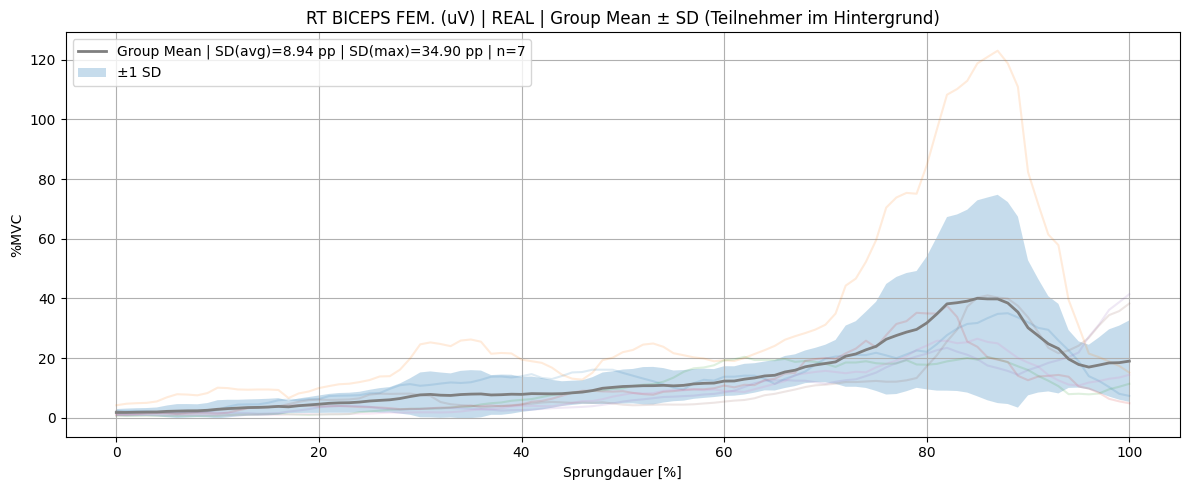

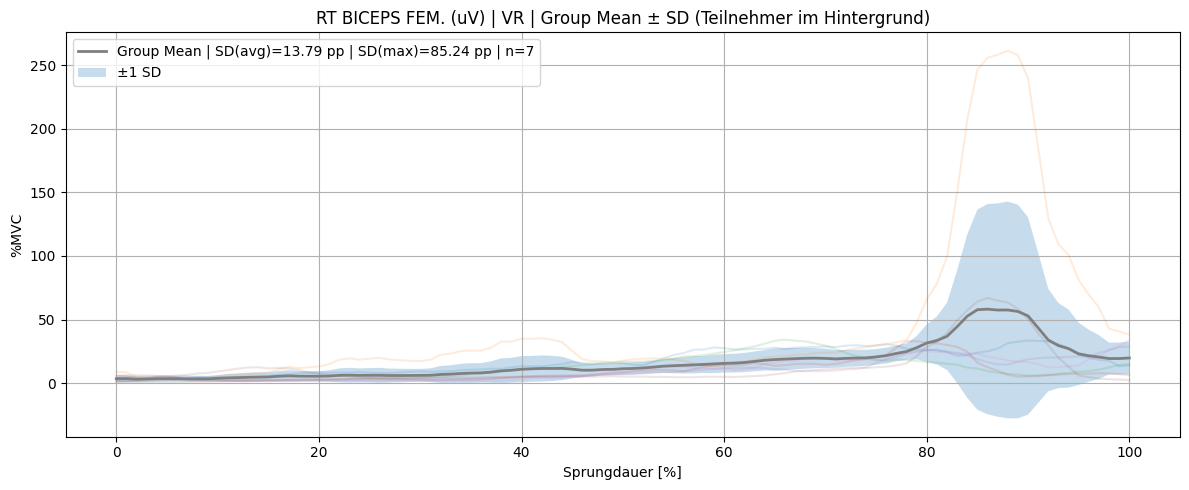

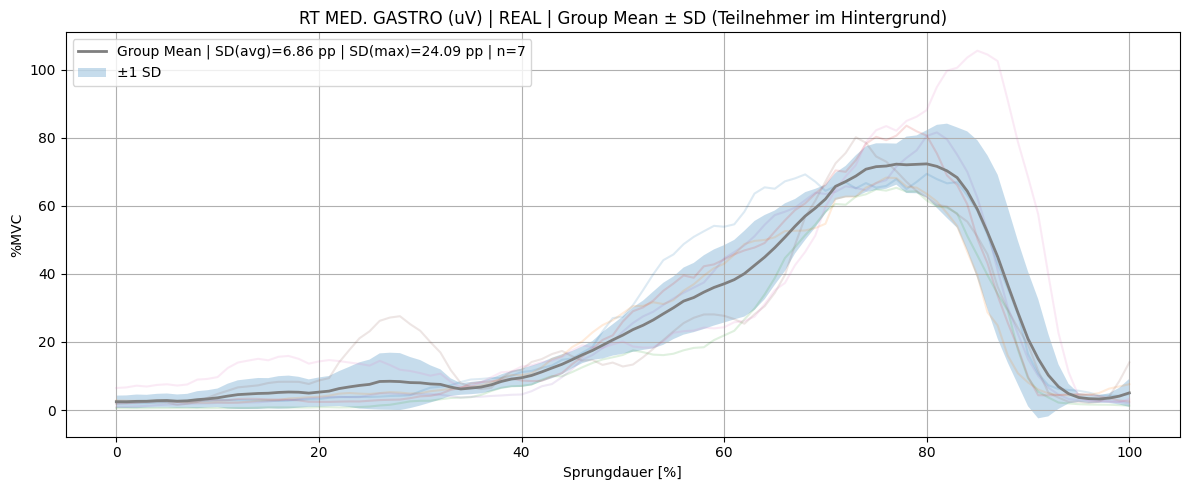

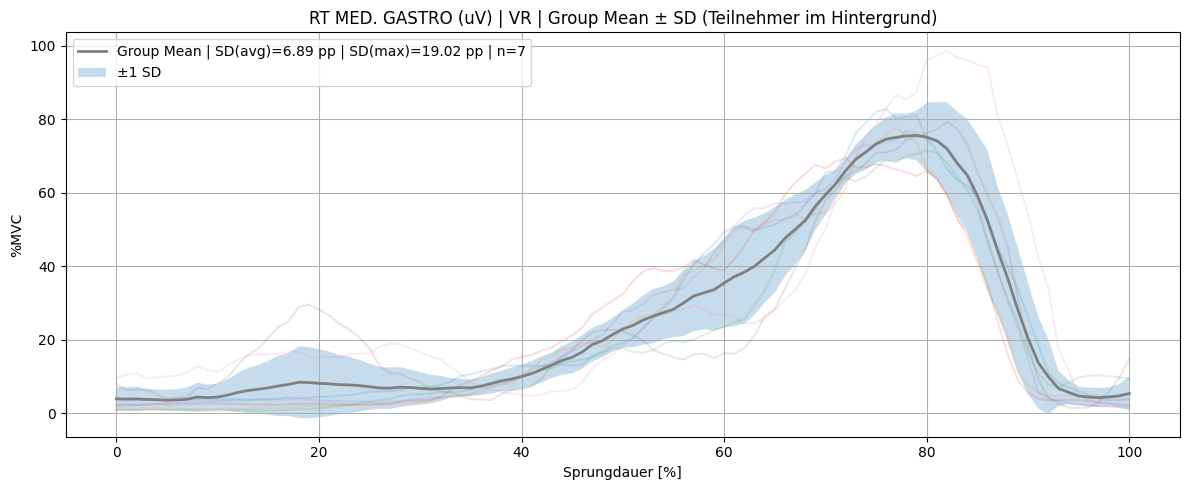

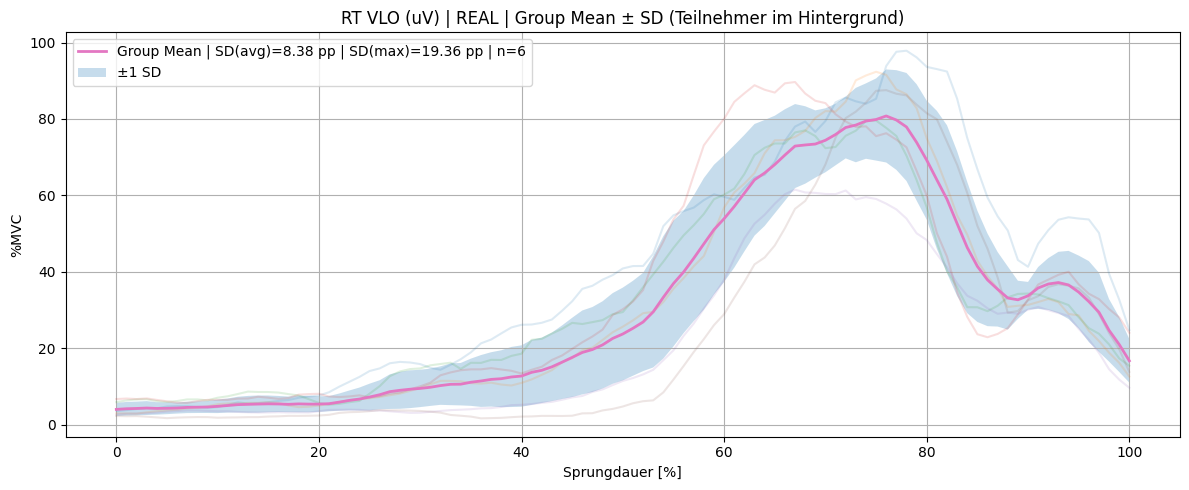

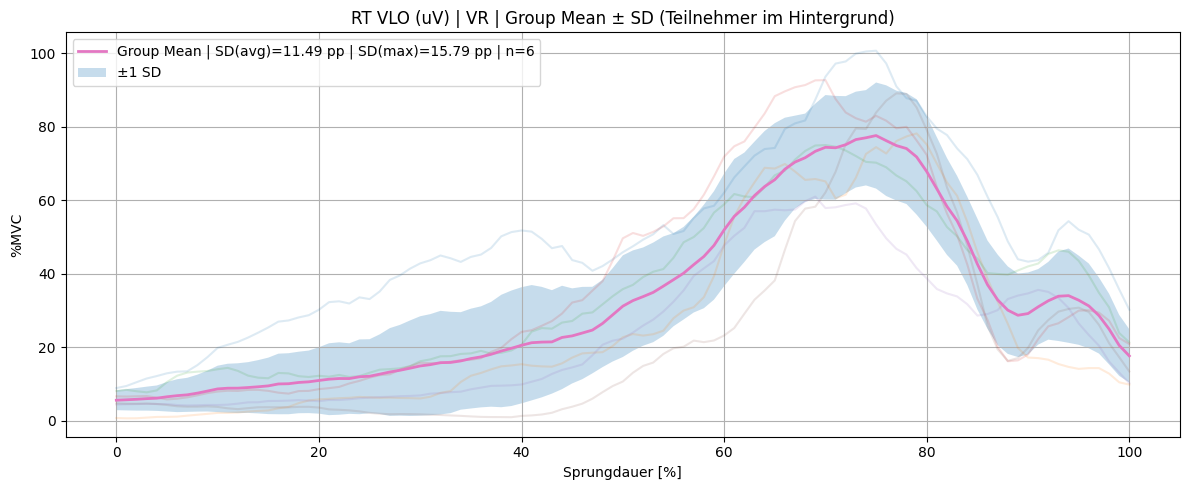

Gespeichert: results_tables_means_by_muscle/EMG_means_REAL_vs_VR_all_3legmuscles.csv


In [38]:
#%% 3 Beinmuskeln: Group Mean±SD Plots (0–100%) + 1 gemeinsame CSV (Layout: Proband, REAL_Muskel1, VR_Muskel1, ...)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

JUMP_DIR = "jump_analysis_results_knee"

TRIALS_REAL = ["REAL_1", "REAL_2"]
TRIALS_VR   = ["VR_1", "VR_2"]
TRIAL_ORDER = {t: i for i, t in enumerate(TRIALS_REAL + TRIALS_VR)}

TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"   # nimmt %MVC wenn vorhanden, sonst RMS

# 3 Beinmuskeln (ohne Tib Ant)
MUSCLES = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)"]

# Excludes (nur Biceps Fem in bestimmten Trials)
MUSCLE_EXCLUDES = {
    "ID_2_Pohl_Jannis": {"REAL_2": ["RT BICEPS FEM. (uV)"]},
    "ID_3_Kleber_Christian": {"REAL_1": ["RT BICEPS FEM. (uV)"]},
    "ID_4_Schröter_Till": {"REAL_2": ["RT BICEPS FEM. (uV)"], "VR_1": ["RT BICEPS FEM. (uV)"]},
}
def is_muscle_excluded(participant: str, trial: str, muscle_raw: str) -> bool:
    return muscle_raw in MUSCLE_EXCLUDES.get(participant, {}).get(trial, [])

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "start_analyse", "t_absprung", "messung"])

    # sortieren (reproduzierbar)
    jumps["trial_order"] = jumps["messung"].map(TRIAL_ORDER)
    jumps = jumps.dropna(subset=["trial_order"]).sort_values(["trial_order", "sprung nr."])
    return jumps

def pick_signal_col(df: pd.DataFrame, muscle_raw: str) -> str:
    col_pct = muscle_raw + RMS_SUFFIX + OUT_SUFFIX
    col_rms = muscle_raw + RMS_SUFFIX
    if col_pct in df.columns:
        return col_pct
    if col_rms in df.columns:
        return col_rms
    return None

def extract_segments(df_trial: pd.DataFrame, jumps_trial: pd.DataFrame, time_col="time"):
    segs = []
    for _, r in jumps_trial.iterrows():
        t0 = float(r["start_analyse"])
        t1 = float(r["t_absprung"])
        if t1 <= t0:
            continue
        mask = (df_trial[time_col] >= t0) & (df_trial[time_col] <= t1)
        if mask.sum() < 2:
            continue
        segs.append(df_trial.loc[mask].copy())
    return segs

def resample_to_percent(seg: pd.DataFrame, value_col: str, time_col="time", n_points=101):
    t = seg[time_col].to_numpy(dtype=float)
    y = seg[value_col].to_numpy(dtype=float)
    m = np.isfinite(t) & np.isfinite(y)
    t = t[m]; y = y[m]
    if t.size < 2:
        return None
    t0, t1 = t[0], t[-1]
    if t1 <= t0:
        return None
    tn = (t - t0) / (t1 - t0)  # 0..1
    x_new = np.linspace(0, 1, n_points)
    y_new = np.interp(x_new, tn, y)
    return y_new

def muscle_short(m: str) -> str:
    # Excel-freundlicher Name
    return (m.replace(" (uV)", "")
             .replace("RT ", "")
             .replace(".", "")
             .strip())

N_POINTS = 101
x_pct = np.linspace(0, 100, N_POINTS)

# mean_curves[muscle][condition][participant] = 1D array (0..100%)
mean_curves = {m: {"REAL": {}, "VR": {}} for m in MUSCLES}

# scalar_means[muscle][participant] = {"REAL": scalar, "VR": scalar}
scalar_means = {m: {} for m in MUSCLES}

# ------------------ BUILD curves + scalars ------------------
for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    for muscle in MUSCLES:
        scalar_means[muscle][participant] = {"REAL": np.nan, "VR": np.nan}

        for cond_name, trials_group in [("REAL", TRIALS_REAL), ("VR", TRIALS_VR)]:
            curves = []
            jump_means = []

            for trial in trials_group:
                if is_muscle_excluded(participant, trial, muscle):
                    continue

                df_trial = all_data[participant].get(trial, None)
                if df_trial is None or TIME_COL not in df_trial.columns:
                    continue

                col = pick_signal_col(df_trial, muscle)
                if col is None or col not in df_trial.columns:
                    continue

                jsub = jumps_df[jumps_df["messung"] == trial]
                if jsub.empty:
                    continue

                segments = extract_segments(df_trial, jsub, time_col=TIME_COL)

                for seg in segments:
                    # scalar mean pro Sprung
                    vals = seg[col].to_numpy(dtype=float)
                    vals = vals[np.isfinite(vals)]
                    if vals.size > 0:
                        jump_means.append(float(np.mean(vals)))

                    # curve 0..100%
                    y_new = resample_to_percent(seg, col, time_col=TIME_COL, n_points=N_POINTS)
                    if y_new is not None:
                        curves.append(y_new)

            # participant mean-curve
            if len(curves) > 0:
                Y = np.vstack(curves)
                mean_curve = np.nanmean(Y, axis=0)
                mean_curves[muscle][cond_name][participant] = mean_curve

            # participant scalar mean (über Sprünge)
            if len(jump_means) > 0:
                scalar_means[muscle][participant][cond_name] = float(np.mean(jump_means))

# ------------------ PLOTS: pro Muskel & Bedingung Gruppen-Mean ± SD, Teilnehmer im Hintergrund ------------------
for muscle in MUSCLES:
    for cond in ["REAL", "VR"]:
        curves = []
        for participant in participants:
            if participant in mean_curves[muscle][cond]:
                curves.append(mean_curves[muscle][cond][participant])

        if len(curves) == 0:
            print(f"Keine Kurven für {muscle} | {cond}")
            continue

        Y = np.vstack(curves)
        group_mean = np.nanmean(Y, axis=0)
        group_sd   = np.nanstd(Y, axis=0)

        sd_mean_pp = float(np.nanmean(group_sd))
        sd_max_pp  = float(np.nanmax(group_sd))

        plt.figure(figsize=(12, 5))

        # einzelne Teilnehmerkurven
        for y in Y:
            plt.plot(x_pct, y, alpha=0.15)

        # Gruppenmean ± SD
        plt.plot(
            x_pct, group_mean, linewidth=2,
            label=f"Group Mean | SD(avg)={sd_mean_pp:.2f} pp | SD(max)={sd_max_pp:.2f} pp | n={Y.shape[0]}"
        )
        plt.fill_between(x_pct, group_mean - group_sd, group_mean + group_sd, alpha=0.25, label="±1 SD")

        plt.title(f"{muscle} | {cond} | Group Mean ± SD (Teilnehmer im Hintergrund)")
        plt.xlabel("Sprungdauer [%]")
        plt.ylabel("%MVC" if OUT_SUFFIX else "EMG RMS")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# ------------------ 1 GEMEINSAME CSV: Layout wie Bild (Proband, REAL_MUSKEL1, VR_MUSKEL1, ...) ------------------
OUT_DIR = "results_tables_means_by_muscle"
os.makedirs(OUT_DIR, exist_ok=True)

rows = []
for participant in participants:
    row = {"Proband": participant}
    for muscle in MUSCLES:
        mname = muscle_short(muscle)
        row[f"REAL_{mname}"] = scalar_means[muscle][participant]["REAL"]
        row[f"VR_{mname}"]   = scalar_means[muscle][participant]["VR"]
    rows.append(row)

df_out = pd.DataFrame(rows)

# saubere Spaltenreihenfolge
cols = ["Proband"]
for muscle in MUSCLES:
    mname = muscle_short(muscle)
    cols += [f"REAL_{mname}", f"VR_{mname}"]
df_out = df_out[cols]

out_path = os.path.join(OUT_DIR, "EMG_means_REAL_vs_VR_all_3legmuscles.csv")
df_out.to_csv(out_path, sep=";", index=False)
print("Gespeichert:", out_path)

## RT SCM: Absprung-zentriertes Fenster [-0.5s, +1.0s] | Group Mean±SD Plots + CSV (Proband|REAL|VR)

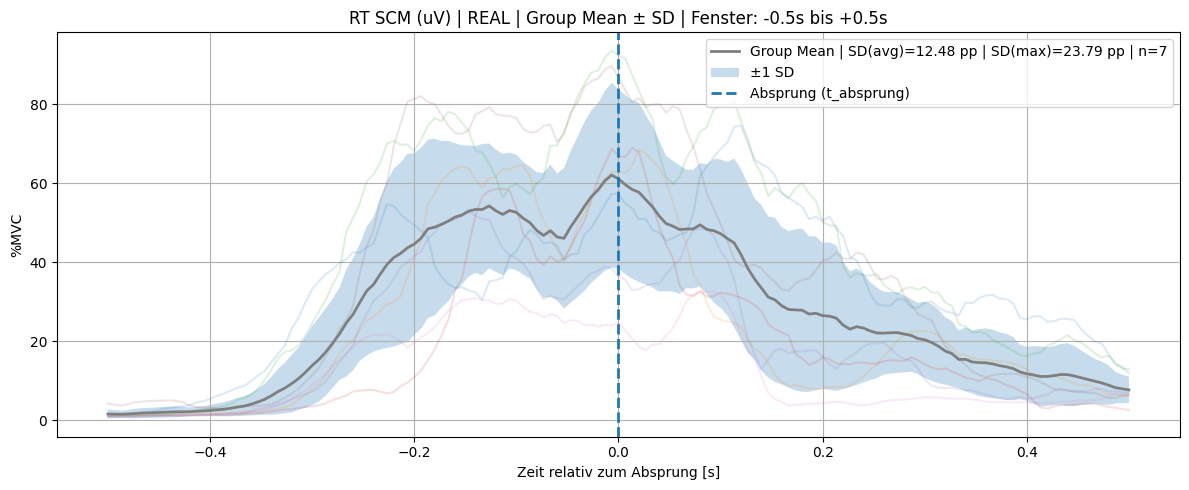

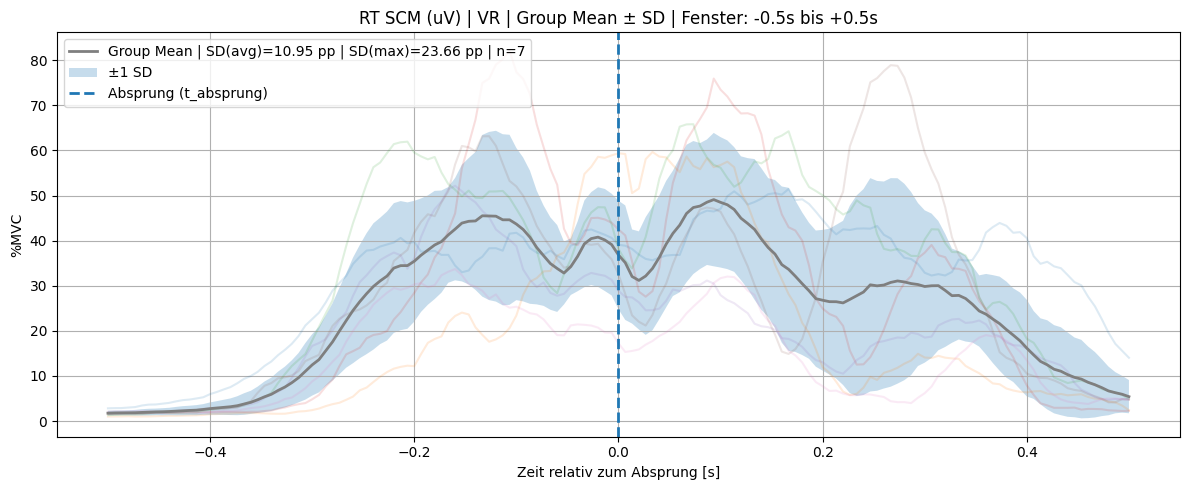

Gespeichert: results_tables_means_by_muscle/RT_SCM_means_REAL_vs_VR_absprung_window.csv


In [40]:
JUMP_DIR = "jump_analysis_results_knee"

TRIALS_REAL = ["REAL_1", "REAL_2"]
TRIALS_VR   = ["VR_1", "VR_2"]

TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"   # nimmt %MVC wenn vorhanden, sonst RMS

MUSCLE_SCM = "RT SCM (uV)"

# Fenster um Absprung:
WINDOW_PRE  = 0.5   # s vor Absprung
WINDOW_POST = 0.5   # s nach Absprung
N_POINTS = 151      # Resampling Punkte fürs Fenster

# gleiche Excludes wie vorher (betrifft SCM normalerweise nicht, bleibt aber als Safety)
MUSCLE_EXCLUDES = {
    "ID_2_Pohl_Jannis": {"REAL_2": ["RT BICEPS FEM. (uV)"]},
    "ID_3_Kleber_Christian": {"REAL_1": ["RT BICEPS FEM. (uV)"]},
    "ID_4_Schröter_Till": {"REAL_2": ["RT BICEPS FEM. (uV)"], "VR_1": ["RT BICEPS FEM. (uV)"]},
}
def is_muscle_excluded(participant: str, trial: str, muscle_raw: str) -> bool:
    return muscle_raw in MUSCLE_EXCLUDES.get(participant, {}).get(trial, [])

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "t_absprung", "messung"])
    return jumps

def pick_signal_col(df: pd.DataFrame, muscle_raw: str) -> str:
    col_pct = muscle_raw + RMS_SUFFIX + OUT_SUFFIX
    col_rms = muscle_raw + RMS_SUFFIX
    if col_pct in df.columns:
        return col_pct
    if col_rms in df.columns:
        return col_rms
    return None

def resample_fixed_window(t_rel: np.ndarray, y: np.ndarray, n_points: int, t_min: float, t_max: float):
    m = np.isfinite(t_rel) & np.isfinite(y)
    t_rel = t_rel[m]
    y = y[m]
    if t_rel.size < 2:
        return None

    order = np.argsort(t_rel)
    t_rel = t_rel[order]
    y = y[order]

    x_new = np.linspace(t_min, t_max, n_points)
    y_new = np.interp(x_new, t_rel, y)
    return x_new, y_new

x_win = np.linspace(-WINDOW_PRE, WINDOW_POST, N_POINTS)

# participant_curves[cond][participant] = mean curve over jumps (resampled)
participant_curves = {"REAL": {}, "VR": {}}

# scalar_means: mean over time-window per jump, then mean over jumps (per condition)
scalar_means = {p: {"REAL": np.nan, "VR": np.nan} for p in participants}

for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    for cond, trials_group in [("REAL", TRIALS_REAL), ("VR", TRIALS_VR)]:
        curves = []
        jump_means = []

        for trial in trials_group:
            if is_muscle_excluded(participant, trial, MUSCLE_SCM):  # wird i.d.R. nie true
                continue

            df = all_data[participant].get(trial, None)
            if df is None or TIME_COL not in df.columns:
                continue

            col = pick_signal_col(df, MUSCLE_SCM)
            if col is None or col not in df.columns:
                continue

            jsub = jumps_df[jumps_df["messung"] == trial]
            if jsub.empty:
                continue

            t = df[TIME_COL].to_numpy(dtype=float)
            y = df[col].to_numpy(dtype=float)

            for _, r in jsub.iterrows():
                t_abs = float(r["t_absprung"])
                t0 = t_abs - WINDOW_PRE
                t1 = t_abs + WINDOW_POST

                mask = (t >= t0) & (t <= t1)
                if np.sum(mask) < 2:
                    continue

                t_rel = t[mask] - t_abs
                y_seg = y[mask]

                res = resample_fixed_window(t_rel, y_seg, N_POINTS, -WINDOW_PRE, WINDOW_POST)
                if res is None:
                    continue

                _, y_new = res
                curves.append(y_new)

                vals = y_seg[np.isfinite(y_seg)]
                if vals.size > 0:
                    jump_means.append(float(np.mean(vals)))

        if len(curves) > 0:
            Y = np.vstack(curves)
            participant_curves[cond][participant] = np.nanmean(Y, axis=0)

        if len(jump_means) > 0:
            scalar_means[participant][cond] = float(np.mean(jump_means))

# --------- PLOTS: Group Mean ± SD, Teilnehmer im Hintergrund (REAL & VR) ----------
for cond in ["REAL", "VR"]:
    curves = []
    for participant in participants:
        if participant in participant_curves[cond]:
            curves.append(participant_curves[cond][participant])

    if len(curves) == 0:
        print(f"Keine Kurven für RT SCM | {cond}")
        continue

    Y = np.vstack(curves)
    group_mean = np.nanmean(Y, axis=0)
    group_sd   = np.nanstd(Y, axis=0)

    sd_mean_pp = float(np.nanmean(group_sd))
    sd_max_pp  = float(np.nanmax(group_sd))

    plt.figure(figsize=(12, 5))

    for y_curve in Y:
        plt.plot(x_win, y_curve, alpha=0.15)

    plt.plot(
        x_win, group_mean, linewidth=2,
        label=f"Group Mean | SD(avg)={sd_mean_pp:.2f} pp | SD(max)={sd_max_pp:.2f} pp | n={Y.shape[0]}"
    )
    plt.fill_between(x_win, group_mean - group_sd, group_mean + group_sd, alpha=0.25, label="±1 SD")
    plt.axvline(0, linestyle="--", linewidth=2, label="Absprung (t_absprung)")

    plt.title(f"{MUSCLE_SCM} | {cond} | Group Mean ± SD | Fenster: -{WINDOW_PRE}s bis +{WINDOW_POST}s")
    plt.xlabel("Zeit relativ zum Absprung [s]")
    plt.ylabel("%MVC" if OUT_SUFFIX else "EMG RMS")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------- CSV: Layout wie Bild (Proband | REAL | VR) ----------
OUT_DIR = "results_tables_means_by_muscle"
os.makedirs(OUT_DIR, exist_ok=True)

rows = []
for participant in participants:
    rows.append({
        "Proband": participant,
        "REAL": scalar_means[participant]["REAL"],
        "VR":   scalar_means[participant]["VR"],
    })

df_out = pd.DataFrame(rows)
out_path = os.path.join(OUT_DIR, "RT_SCM_means_REAL_vs_VR_absprung_window.csv")
df_out.to_csv(out_path, sep=";", index=False)
print("Gespeichert:", out_path)